In [4]:
import random
import torch.nn as nn
import torch
import pickle
import pandas as pd
from pandas import Series, DataFrame
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, matthews_corrcoef, f1_score, precision_score, recall_score
import numpy as np
import torch.optim as optim
folder = "/data/AIpep-clean/"
import matplotlib.pyplot as plt
from vocabulary import Vocabulary
from datasethem import Dataset, collate_fn
from models import Classifier
import os

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Load data

In [5]:
df = pd.read_pickle(folder + "pickles/DAASP_RNN_dataset_with_hemolysis.plk")
df = df.query("isNotHemolytic==1 or isNotHemolytic==0").copy()
df_training = df[df["Set"]=="training"]
df_test = df[df["Set"]=="test"]

vocabulary = Vocabulary.get_vocabulary_from_sequences(df_training.Sequence.values)

if torch.cuda.is_available():
    device = "cuda" 
else:
    device = "cpu" 

# Define helper functions

In [3]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return category_i

def nan_equal(a,b):
    try:
        np.testing.assert_equal(a,b)
    except AssertionError:
        return False
    return True

def models_are_equal(model1, model2):
    model1.vocabulary == model2.vocabulary
    model1.hidden_size == model2.hidden_size
    for a,b in zip(model1.model.parameters(), model2.model.parameters()):
        if nan_equal(a.detach().numpy(), b.detach().numpy()) == True:
            print("true")

# Define model

In [4]:
def training(model, test_dataloader, training_dataloader, n_epoch, optimizer, filename):
    
    roc_training = []
    roc_test = []
    
    for e in range(1, n_epoch + 1):
        for i_batch, sample_batched in enumerate(training_dataloader):
            seq_batched = sample_batched[0][0].to(model.device, non_blocking=True)
            seq_lengths = sample_batched[0][1].to(model.device, non_blocking=True)
            cat_batched = sample_batched[1].to(model.device, non_blocking=True)

            output = model.evaluate(seq_batched, seq_lengths)

            loss = criterion(output, cat_batched)

            optimizer.zero_grad()
            loss.backward()  
            torch.nn.utils.clip_grad_value_(model.model.parameters(), 2)
            optimizer.step()

        model.save(filename.format(e))
        
        def _evaluate_ROC(data_loader):
            cat_list = []
            out_list = []

            with torch.no_grad():
                for i_batch, sample_batched in enumerate(data_loader):    
                    seq_batched = sample_batched[0][0].to(model.device, non_blocking=True)
                    seq_lengths = sample_batched[0][1].to(model.device, non_blocking=True)
                    
                    cat_list += sample_batched[1].to("cpu", non_blocking=True)
                    out_list += torch.exp(model.evaluate(seq_batched, seq_lengths))[: ,1].to("cpu", non_blocking=True)

                cat_list = torch.stack(cat_list)
                out_list = torch.stack(out_list)

                roc = roc_auc_score(cat_list.cpu().numpy().astype(int), out_list.cpu().numpy())
            return roc
        
        roc_tr = _evaluate_ROC(training_dataloader)
        roc_te = _evaluate_ROC(test_dataloader)
        roc_training.append(roc_tr)
        roc_test.append(roc_te)
        print("epoch: " + str(e))
        print("roc auc training: " + str(roc_tr))
        print("roc auc test: " + str(roc_te))
        if roc_training == 1.0:
            break
        
    return model, optimizer, roc_training, roc_test
        

In [5]:
learning_rate = 0.01
momentum = 0.9
batch_size = 20
n_epoch = 150
criterion = nn.NLLLoss()

# Hyper parameters optimization

In [3]:
n_embeddings  = [2, 21, 42, 100]
n_hiddens = [50, 100, 200, 300, 400]
n_layerss = [1, 2,3]
    
if not os.path.exists(folder+"pickles/classifier_hyperparameter_optimization_results_hem.pkl"):
    df_opt = df_training.copy()
    # create an evaluation/training set only from the training set
    # assign to training or evaluation set
    df_opt["Set2"] = "eval"
    training_ = df_opt.sample(frac=0.75, random_state=0)
    df_opt.loc[training_.index, "Set2"] = "training"

    df_training = df_opt[df_opt["Set2"]=="training"]
    df_eval = df_opt[df_opt["Set2"]=="eval"]

    training_dataset = Dataset(df_training, vocabulary)
    eval_dataset = Dataset(df_eval, vocabulary)

    training_dict = {}
    for  n_embedding in n_embeddings:
        for n_hidden in n_hiddens:
            for n_layers in n_layerss:

                if "em{}_hi{}_la{}".format(n_embedding, n_hidden, n_layers) in training_dict:
                    continue

                print(f"dimensions of embedding {n_embedding}, dimensions of hidden {n_hidden}, number of layers {n_layers}")
                model = Classifier(n_embedding, n_hidden, n_layers, vocabulary)
                model.to(device)
                optimizer = optim.SGD(model.model.parameters(), lr = learning_rate, momentum=momentum)
                training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, collate_fn = collate_fn, drop_last=True, pin_memory=True, num_workers=4)
                test_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size, shuffle=True, collate_fn = collate_fn, drop_last=True, pin_memory=True, num_workers=4)
                filename = folder+"models/RNN-classifier-hem/em{}_hi{}_la{}_ep{{}}".format(n_embedding, n_hidden, n_layers)
                model, optimizer, roc_training, roc_test = training(model, test_dataloader, training_dataloader, n_epoch, optimizer, filename)
                training_dict["em{}_hi{}_la{}".format(n_embedding, n_hidden, n_layers)] = [roc_training, roc_test]
                print(f"maximum roc auc for test set {max(roc_test)}")

    with open(folder+"pickles/classifier_hyperparameter_optimization_results_hem.pkl","bw") as fd:
        pickle.dump(training_dict, fd)
else:
    with open(folder+"pickles/classifier_hyperparameter_optimization_results_hem.pkl",'rb') as fd:
        training_dict = pickle.load(fd)

# Optimized hyper parameters

In [4]:
max_test = 0
for k,v in training_dict.items():
    if max(v[1]) > max_test:
        max_test = max(v[1])
        best = k
best = best.split("_")
n_embedding = int(best[0].replace("em", ""))
n_hidden = int(best[1].replace("hi", ""))
n_layers = int(best[2].replace("la", ""))

# Training

training_dataset = Dataset(df_training, vocabulary)
test_dataset = Dataset(df_test, vocabulary)

print(f"dimensions of embedding {n_embedding}, dimensions of hidden {n_hidden}, number of layers {n_layers}")

model = Classifier(n_embedding, n_hidden, n_layers, vocabulary)
model.to(device)

optimizer = optim.SGD(model.model.parameters(), lr = learning_rate, momentum=momentum)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, collate_fn = collate_fn, drop_last=True, pin_memory=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn = collate_fn, drop_last=True, pin_memory=True, num_workers=4)

filename = folder + "/models/RNN-classifier-hem/em{}_hi{}_la{}_ep{{}}".format(n_embedding, n_hidden, n_layers)
model, optimizer, roc_training, roc_test = training(model, test_dataloader, training_dataloader, n_epoch, optimizer, filename)

print(f"maximum roc auc for test set {max(roc_test)}")


roc_test = np.array(roc_test)
epoch = np.argmax(roc_test) + 1

In [9]:
training_dataset = Dataset(df_training, vocabulary)
test_dataset = Dataset(df_test, vocabulary)


In [10]:
folder = "/data/AIpep/"
epoch = 95
n_embedding=100 
n_hidden=400
n_layers=1

print(n_embedding, n_hidden, n_layers, epoch)

filename = folder + "models/RNN-classifier-hem/em{}_hi{}_la{}_ep{}".format(n_embedding, n_hidden, n_layers, epoch)

model = Classifier.load_from_file(filename)

model.to(device)


100 400 1 95


ClassifierRNN(
  (embedding): Embedding(42, 100)
  (rnn): GRU(100, 400, batch_first=True)
  (output_layer): Linear(in_features=400, out_features=2, bias=True)
  (softmax): LogSoftmax()
)

n_embedding, n_hidden, n_layers, epoch : 
100 400 1 95

# Evaluation

In [11]:

training_dataloader_eval = torch.utils.data.DataLoader(training_dataset, batch_size=1, shuffle=False, collate_fn = collate_fn, drop_last=True, pin_memory=True, num_workers=4)
test_dataloader_eval = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn = collate_fn, drop_last=True, pin_memory=True, num_workers=4)

In [12]:
def predict(data_loader):
    cat_list = []
    out_list = []

    with torch.no_grad():
        for i_batch, sample_batched in enumerate(data_loader):    
            seq_batched = sample_batched[0][0].to(model.device, non_blocking=True)
            seq_lengths = sample_batched[0][1].to(model.device, non_blocking=True)

            cat_list += sample_batched[1].to("cpu", non_blocking=True)
            out_list += torch.exp(model.evaluate(seq_batched, seq_lengths))[: ,1].to("cpu", non_blocking=True)

        cat_list = torch.stack(cat_list)
        out_list = torch.stack(out_list)
    return cat_list.cpu().numpy().astype(int), out_list.cpu().numpy()

def roc(y_true, y_score):
    fpr, tpr, thresh = roc_curve(y_true, y_score)
    roc = roc_auc_score(y_true, y_score)
    return roc, fpr, tpr
                
def find_threshold(y_true, y_score, alpha = 0.05):
    fpr, tpr, thresh = roc_curve(y_true, y_score)
    for i, fp in enumerate(fpr):
        if fp > alpha:
            return thresh[i-1]
        
def calc_metrics(y_true, y_score, threshold = 0.5):
    y_score = y_score > threshold
    accuracy = accuracy_score(y_true, y_score)
    f1 = f1_score(y_true, y_score)
    mcc = matthews_corrcoef(y_true, y_score)
    precision = precision_score(y_true, y_score)
    recall = recall_score(y_true, y_score)
    return accuracy, f1, mcc, precision, recall

def swap_labels(pred):
    inverse = np.ones_like(pred)
    return inverse-pred

In [13]:
y_true, y_score = predict(test_dataloader_eval)
threshold = find_threshold(y_true, y_score)

In [20]:
threshold=0.99981695 

0.99981695


In [21]:
accuracy, f1, mcc, precision, recall = calc_metrics(y_true, y_score, threshold)
print(f"accuracy: {accuracy}\nf1 score: {f1}\nmcc: {mcc}\nprecision: {precision}\nrecall: {recall}" )

accuracy: 0.7217068645640075
f1 score: 0.5562130177514792
mcc: 0.4359103179049204
precision: 0.8392857142857143
recall: 0.415929203539823


accuracy: 0.7217068645640075
f1 score: 0.5562130177514792
mcc: 0.4359103179049204
precision: 0.8392857142857143
recall: 0.415929203539823

In [19]:
accuracy, f1, mcc, precision, recall = calc_metrics(y_true, y_score, 0.5)
print(f"accuracy: {accuracy}\nf1 score: {f1}\nmcc: {mcc}\nprecision: {precision}\nrecall: {recall}")

accuracy: 0.764378478664193
f1 score: 0.7292110874200427
mcc: 0.5222308880322533
precision: 0.7037037037037037
recall: 0.7566371681415929


accuracy: 0.764378478664193
f1 score: 0.7292110874200427
mcc: 0.5222308880322533
precision: 0.7037037037037037
recall: 0.7566371681415929

In [43]:
df["Hemolysis_pred"] = df.Sequence.map(lambda x: model.predict_peptide_sequence(x)[:,1][0])

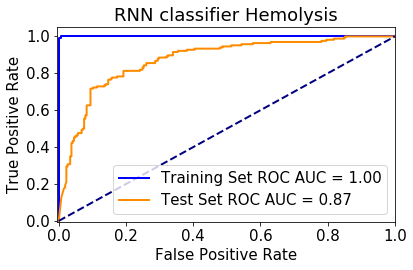

In [44]:
Y_true, Y_score = predict(training_dataloader_eval) 
roc_training, fpr_training, tpr_training = roc(Y_true, Y_score)
y_true, y_score = predict(test_dataloader_eval)
roc_test, fpr_test, tpr_test = roc(y_true, y_score)

plt.figure()
name = "RNN classifier Hemolysis"
plt.rcParams.update({'font.size': 15})
lw = 2
plt.plot(fpr_training, tpr_training, color='blue',
         lw=lw, label='Training Set ROC AUC = %0.2f' % roc_training)
plt.plot(fpr_test, tpr_test, color='darkorange',
         lw=lw, label='Test Set ROC AUC = %0.2f' % roc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.005, 1.0])
plt.ylim([-0.005, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(name)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(folder+"plots/RNN-classifier-hem.svg")
plt.savefig("plots/RNN-classifier-hem.svg")
plt.show()

In [45]:
df.to_pickle(folder + "pickles/DAASP_RNN_dataset_with_hem_and_prediction_hem.plk")

In [9]:
gram_neg = pd.read_csv("data/gram_neg_filtered_clustered.csv")

In [10]:
gram_neg.columns

Index(['ID', 'Sequence', 'prediction', 'length', 'dist_Training',
       'NN_Training', 'dist_Test', 'NN_Test', 'map_dist_Training',
       'map_NN_Training', 'map_dist_Test', 'map_NN_Test',
       'fraction_PredHelical', 'HydroMoment', 'SMILES', 'MAP4'],
      dtype='object')

In [11]:
gram_neg["Hemolysis_pred"] = gram_neg.Sequence.map(lambda x: model.predict_peptide_sequence(x)[:,1][0])

In [16]:
gram_neg["isPredNotHemolytic_0.5"] = gram_neg["Hemolysis_pred"] > 0.5

In [18]:
gram_neg["isPredNotHemolytic_0.99981695"] = gram_neg["Hemolysis_pred"] > 0.99981695

In [50]:
from rdkit.Chem import Descriptors
from rdkit import Chem
def MW(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mw = Descriptors.ExactMolWt(mol)
    return mw

In [51]:
gram_neg["MW"] = gram_neg["SMILES"].map(MW)

In [19]:
gram_neg[["ID", "isPredNotHemolytic_0.5", "isPredNotHemolytic_0.99981695"]]

,ID,isPredNotHemolytic_0.5,isPredNotHemolytic_0.99981695
0,gen_gramneg_3259,True,False
1,gen_gramneg_3593,False,False
2,gen_gramneg_24767,True,True
3,gen_gramneg_9907,True,False
4,gen_gramneg_40529,False,False
5,gen_gramneg_1841,True,False
6,gen_gramneg_40954,True,False
7,gen_gramneg_31595,False,False
8,gen_gramneg_41073,False,False
9,gen_gramneg_40577,False,False


In [20]:
gram_pos = pd.read_csv("data/gram_pos_filtered_clustered.csv")

In [21]:
gram_pos["Hemolysis_pred"] = gram_pos.Sequence.map(lambda x: model.predict_peptide_sequence(x)[:,1][0])

In [23]:
gram_pos["isPredNotHemolytic_0.5"] = gram_pos["Hemolysis_pred"] > 0.5

In [24]:
gram_pos["isPredNotHemolytic_0.99981695"] = gram_pos["Hemolysis_pred"] > 0.99981695

In [56]:
gram_pos["isPredNotHemolytic"] = gram_pos["Hemolysis_pred"] > threshold

In [25]:
gram_pos[["ID","isPredNotHemolytic_0.5","isPredNotHemolytic_0.99981695"]]

,ID,isPredNotHemolytic_0.5,isPredNotHemolytic_0.99981695
0,gen_grampos_8322,False,False
1,gen_grampos_25946,True,False
2,gen_grampos_9242,True,False
3,gen_grampos_43471,False,False
4,gen_grampos_12206,True,True
5,gen_grampos_25356,False,False
6,gen_grampos_3890,False,False
7,gen_grampos_19658,True,False
8,gen_grampos_11272,False,False
9,gen_grampos_28916,False,False


In [59]:
gram_pos_rnd = pd.read_csv("data/gram_pos_rnd.csv")
gram_neg_rnd = pd.read_csv("data/gram_neg_rnd.csv")

In [60]:
gram_pos_rnd["Hemolysis_pred"] = gram_pos_rnd.Sequence.map(lambda x: model.predict_peptide_sequence(x)[:,1][0])
gram_neg_rnd["Hemolysis_pred"] = gram_neg_rnd.Sequence.map(lambda x: model.predict_peptide_sequence(x)[:,1][0])
gram_pos_rnd["isPredNotHemolytic"] = gram_pos_rnd["Hemolysis_pred"] > threshold
gram_neg_rnd["isPredNotHemolytic"] = gram_neg_rnd["Hemolysis_pred"] > threshold

In [1]:
gram_pos_rnd[["ID","isPredNotHemolytic",'Hemolysis_pred']]

NameError: name 'gram_pos_rnd' is not defined

In [62]:
gram_neg_rnd[["ID","isPredNotHemolytic",'fraction_PredHelical', 'HydroMoment']]

,ID,isPredNotHemolytic,fraction_PredHelical,HydroMoment
0,gen_gramneg_37060,False,0.857143,0.476070
1,gen_gramneg_3140,False,0.000000,0.174339
2,gen_gramneg_35148,False,0.857143,0.483206
3,gen_gramneg_5558,False,0.866667,0.219135
4,gen_gramneg_30079,False,0.000000,0.426619
5,gen_gramneg_14047,False,0.857143,0.466460
6,gen_gramneg_39078,False,0.846154,0.424280
7,gen_gramneg_41985,False,0.857143,0.433182
8,gen_gramneg_1464,False,0.000000,0.360781
9,gen_gramneg_40225,True,0.866667,0.537106


In [26]:
anticancer = pd.read_csv("anticancers/biores_anticancer.csv", sep =";")

In [65]:
anticancer.columns

Index(['Code', 'Sequence', 'Selection', 'Length', 'IC50, uM, ', 'MHC, ug/ml',
       'Hemolytic? (C<125 ug/ml) ', 'PredHelical', 'HydroMoment'],
      dtype='object')

In [27]:
anticancer = anticancer.drop(anticancer.index[[0]])

In [28]:
anticancer["Hemolysis_pred"] = anticancer.Sequence.map(lambda x: model.predict_peptide_sequence(x)[:,1][0])

In [68]:
anticancer["isPredNotHemolytic"] = anticancer["Hemolysis_pred"] > threshold

In [29]:
anticancer["isPredNotHemolytic_0.5"] = anticancer["Hemolysis_pred"] > 0.5
anticancer["isPredNotHemolytic_0.99981695"] = anticancer["Hemolysis_pred"] > 0.99981695

In [30]:
anticancer

,Code,Sequence,Selection,Length,"IC50, uM,","MHC, ug/ml",Hemolytic? (C<125 ug/ml),PredHelical,HydroMoment,Hemolysis_pred,isPredNotHemolytic_0.5,isPredNotHemolytic_0.99981695
1,AC1,WFKRILKYLKKLV,clustered,13.0,9.7,7.81,yes,0.846154,0.534948,1.177792e-05,False,False
2,AC2,KNFKKLMKKVASVL,clustered,14.0,>60,>1000,no,0.857143,0.449182,9.999961e-01,True,True
3,AC3,KWRSKIKKIMRTFK,clustered,14.0,-,-,-,0.857143,0.440264,9.966789e-01,True,False
4,AC4,FAKKFFKKFAKFAFK,clustered,15.0,14.8,500,no,0.866667,0.409642,9.999785e-01,True,True
5,AC5,GLLGRLAKLLANS,clustered,13.0,>75,500,no,0.846154,0.323534,2.411242e-02,False,False
6,AC6,ALWKRVLKIAARIAK,clustered,15.0,8.6,62.5,yes,0.866667,0.477224,1.033869e-08,False,False
7,AC7,SFSKWMGKLKNIFKK,clustered,15.0,>55,1000,no,0.866667,0.375619,1.163046e-01,False,False
8,AC8,WLNALKKILGHLIRH,clustered,15.0,8.1,15.625,yes,0.866667,0.404430,4.197396e-02,False,False
9,AC9,LLRHCLRRIRDRLV,clustered,14.0,>55,>1000,no,0.857143,0.353778,1.000000e+00,True,True
10,AC10,KYLKYLVRLVGRLYR,clustered,15.0,11.0,31.25,yes,0.866667,0.579118,9.999642e-01,True,True


In [38]:
anticancer

,Code,Sequence,Selection,Length,"IC50, uM,","MHC, ug/ml",Hemolytic? (C<125 ug/ml),PredHelical,HydroMoment,Hemolysis_pred,isPredNotHemolytic
1,AC1,WFKRILKYLKKLV,clustered,13.0,9.7,7.81,yes,0.846154,0.534948,1.177792e-05,False
2,AC2,KNFKKLMKKVASVL,clustered,14.0,>60,>1000,no,0.857143,0.449182,9.999961e-01,False
3,AC3,KWRSKIKKIMRTFK,clustered,14.0,-,-,-,0.857143,0.440264,9.966789e-01,False
4,AC4,FAKKFFKKFAKFAFK,clustered,15.0,14.8,500,no,0.866667,0.409642,9.999785e-01,False
5,AC5,GLLGRLAKLLANS,clustered,13.0,>75,500,no,0.846154,0.323534,2.411242e-02,False
6,AC6,ALWKRVLKIAARIAK,clustered,15.0,8.6,62.5,yes,0.866667,0.477224,1.033869e-08,False
7,AC7,SFSKWMGKLKNIFKK,clustered,15.0,>55,1000,no,0.866667,0.375619,1.163046e-01,False
8,AC8,WLNALKKILGHLIRH,clustered,15.0,8.1,15.625,yes,0.866667,0.404430,4.197396e-02,False
9,AC9,LLRHCLRRIRDRLV,clustered,14.0,>55,>1000,no,0.857143,0.353778,1.000000e+00,False
10,AC10,KYLKYLVRLVGRLYR,clustered,15.0,11.0,31.25,yes,0.866667,0.579118,9.999642e-01,False
